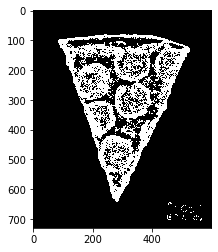

In [436]:
#This program takes an input image and classifies the object as either a circle, square or triangle 
#using a minimum distance filter.

#Declaring required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

#Access and store work image
img_BGR = cv2.imread('pizza.jpg'); #import image
img_GRAY = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY); #convert image to grayscale

#Depending on the image, the thresholding may have to be inversed. The object should be white.
#I recommend using the regular thresholds, but if they dont work for some reason try the adaptive thresholds.
#Also try changing the adaptiveThreshold blocksize value (2nd from end) to a larger odd value.
#This tends to thicken the boundaries of the object, leaving less oportunities for a gap to exist.

#non-inverting thresholds
#ret, img_THRESH = cv2.threshold(img_GRAY, 177, 255, 0); #threshold the image
#img_THRESH = cv2.adaptiveThreshold(img_GRAY, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 2);

#inverting thresholds
#ret, img_THRESH = cv2.threshold(img_GRAY, 127, 255, 1); #threshold the image
img_THRESH = cv2.adaptiveThreshold(img_GRAY, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 2);
    
img = cv2.cvtColor(img_THRESH, cv2.COLOR_GRAY2RGB); #convert thresholded image back to RGB for display
plt.imshow(img); #display BW version of original image
img_ORIGINAL = img.copy(); #copy original image as findContours and drawContours destroy original image.

In [437]:
#Now that the image has been reduced to black and white the contours of the image can be found.
#findContours treats pixel intensity of 0 as 0, and pixel intensity of > 0 as 1.
contours = cv2.findContours(img_THRESH, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)[0]; #finds contours of img
#(image, mode, method)
#mode: RETR_EXTERNAL only external contours. 
#method: CHAIN_APPROX_NONE or CHAIN_APPROX_SIMPLE or CHAIN_APPROX_TC89_L1 or CHAIN_APPROX_TC89_KCOS
#the different methods change the number of points generated
#[0] on end to only specify contour output, no hierarchy, otherwise contours will contain both sets of information

#isolating the largest contour as it is the shape we are interested in
numberOfCnt = np.shape(contours)[0]; #number of contours developed
sizeOfCnt = np.zeros(numberOfCnt); #initialise matrix to store size of contours
for i in range(numberOfCnt): #for each contour
    sizeOfCnt[i] = np.shape(contours[i])[0]; #store the size of contour

for i in range(numberOfCnt-1, -1, -1): #for the array of contours, counting down
    if i != np.argmax(sizeOfCnt): #if the index does not match the index of the largest contour
        del contours[i]; #deleate it
cnt = contours; #set cnt variable with primary contour

#print(np.size(cnt)); #uncomment this line to see the effects of different methods

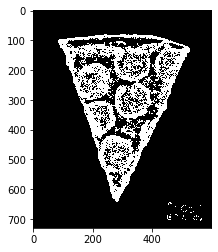

In [438]:
#Displaying the found contour for verification and ease of use
cv2.drawContours(img, cnt, -1, (0,255,0), 3); #adds contours to image for visualisation
plt.imshow(img_ORIGINAL); #original image

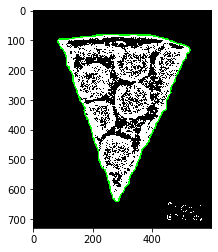

In [439]:
plt.imshow(img); #image with contour

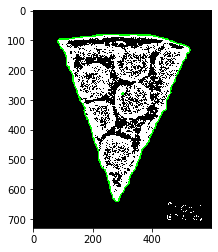

In [440]:
#The centre point of the object may be desireable to know.
#It can be found by calculating the moment of the image.
M = cv2.moments(cnt[0]); #A moment is the weighted average of the images pixel intensities. 
#In this case I think it is the weighted average of the contour, but unsure.
cx = int(M['m10']/M['m00']); #centre point x axis
cy = int(M['m01']/M['m00']); #centre point y axis
#all from this tute https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html
plt.imshow(cv2.circle(img,(cx,cy),5,(0,255,0),-1)); #shows shape with centre point

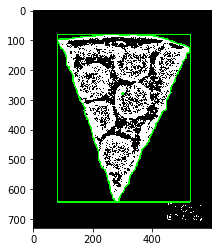

In [441]:
#Calculate the bounding rectangle around the contour
#The bounding rectangle will be used to calculate the area later.
[x,y,w,h] = cv2.boundingRect(cnt[0])#calculates the bounding rectangle xy start point, width and height.
[x1,y1,x2,y2]=[x,y,x+w, y+h]; #xy coords for start and end points
plt.imshow(cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)); #draws bounding box around shape

In [442]:
#Calculating Descriptor Values
#Three discriptors: Compactness, Circularity and Extent
#Compactness: perimeter^2/area
#Circularity: (4*pi*area)/perimeter^2
#Extent: area/boundedArea

perimeter = cv2.arcLength(cnt[0], True); #calculate perimeter
area = cv2.contourArea(cnt[0]); #area of region
boundedArea = w*h; #area of bounded region
pi = m.pi;

print(perimeter, area, boundedArea);

compactness = (perimeter*perimeter)/(area); #compactness of shape
circularity = (4*pi*area)/(perimeter*perimeter); #circularity of shape
extent = (area)/(boundedArea); #extent of shape

imgPattern = np.array([compactness, circularity, extent]); #pattern of image
print(imgPattern);

1655.8732792139053 129764.0 249200
[21.13002309  0.59471637  0.52072231]


In [443]:
#Minimum Distance Classifier Pattern Vectors
#Pattern = [compactness; circularity; extent]
circle = np.array([4*pi, 1, pi/4]); #Pattern of circle
square = np.array([16, pi/4, 1]); #Pattern of square
eTriangle = np.array([36/m.sqrt(3), m.sqrt(3)*pi/9, 1/2]); #Pattern of equilateral triangle
classes = np.array([circle, square, eTriangle]); #Mean patterns of classes
classNames = np.array(["Circle", "Square", "Equilteral Triangle"]); #Name of classes
Nc = classes.shape[0]; #number of classes
print(classes)

[[12.56637061  1.          0.78539816]
 [16.          0.78539816  1.        ]
 [20.78460969  0.60459979  0.5       ]]


In [444]:
#Minimum Distance Classifier
distance = np.zeros(Nc); #initialise matrix to store distance result to each class pattern
for i in range(Nc):
    distanceVector = (imgPattern-classes[i]); #vector from image pattern to class pattern
    #print(distanceVector);
    distance[i] = np.linalg.norm(distanceVector); #calculates linear distance from image pattern to class pattern
#print(distance);
print(classNames[np.argmin(distance)]); #prints the class of the class pattern that was closest to image pattern

Equilteral Triangle
